In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Wed Oct 13 15:20:06 PDT 2021


# Load and clean data, and add `x_factor_effect` to index columns

To avoid having to reset the global index columns in the future, I'd like to add a `universe_id` column to all the tables in the data cleaning step, and use that column instead of `scenario` for the index columns.

In [2]:
data = csr.VivariumResults.cleaned_from_model_spec('4.5.2')
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
vp.set_global_index_columns(vp.INDEX_COLUMNS+['x_factor_effect'])
vp.INDEX_COLUMNS

['input_draw', 'scenario', 'x_factor_effect']

# Create a dictionary to store figures to save later

In [4]:
figs = {}

In [5]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/

v2.1_gbd_2020_wasting	       v2.4_corrected_fertility  v4.5.2_x_factor
v2.3_wasting_birth_prevalence  v2.5_stunting


# Compute x-factor prevalence by age group and year

In [6]:
data.person_time

,age,input_draw,measure,scenario,sex,sq_lns,wasting_treatment,x_factor,x_factor_effect,year,value
0,1-5_months,29,person_time,baseline,female,covered,covered,cat1,1.1,2022,0.000000
1,1-5_months,29,person_time,baseline,female,covered,covered,cat1,1.1,2023,0.000000
2,1-5_months,29,person_time,baseline,female,covered,covered,cat1,1.1,2024,0.000000
3,1-5_months,29,person_time,baseline,female,covered,covered,cat1,1.1,2025,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
86396,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,1.5,2023,50.591376
86397,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,1.5,2024,52.776181
86398,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,1.5,2025,52.197125
86399,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,1.5,2026,49.886379


In [7]:
x_factor_prevalence = csr.get_prevalence(data, 'x_factor', ['age', 'year'], multiplier=100)
x_factor_prevalence

,age,year,input_draw,scenario,x_factor_effect,x_factor,value,numerator_measure,denominator_measure,multiplier
0,1-5_months,2022,29,baseline,1.1,cat1,19.269612,person_time,person_time,100
1,1-5_months,2022,29,baseline,1.1,cat2,80.730388,person_time,person_time,100
2,1-5_months,2022,29,baseline,1.2,cat1,19.269612,person_time,person_time,100
3,1-5_months,2022,29,baseline,1.2,cat2,80.730388,person_time,person_time,100
...,...,...,...,...,...,...,...,...,...,...
10796,late_neonatal,2026,946,wasting_treatment,1.4,cat1,18.454904,person_time,person_time,100
10797,late_neonatal,2026,946,wasting_treatment,1.4,cat2,81.545096,person_time,person_time,100
10798,late_neonatal,2026,946,wasting_treatment,1.5,cat1,18.454904,person_time,person_time,100
10799,late_neonatal,2026,946,wasting_treatment,1.5,cat2,81.545096,person_time,person_time,100


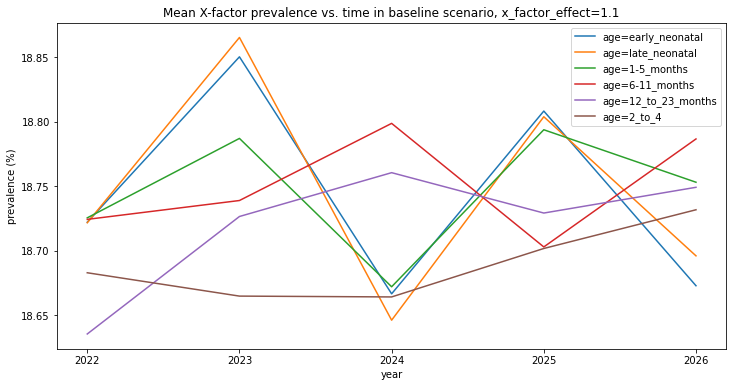

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
x_factor_effect=1.1
csp.plot_over_time_by_column(
    x_factor_prevalence.query(f"x_factor_effect=={x_factor_effect} and scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'prevalence (%)',
    f"Mean X-factor prevalence vs. time in baseline scenario, {x_factor_effect=}",
    False
)
figs['x_factor_prevalence_by_age_group_in_baseline_x_factor_1.1'] = fig

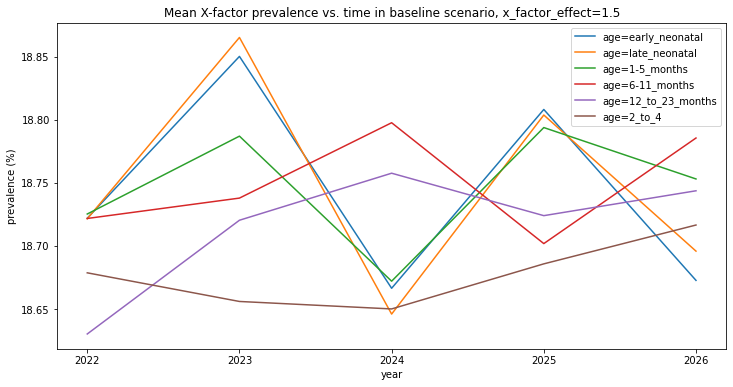

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
x_factor_effect=1.5
csp.plot_over_time_by_column(
    x_factor_prevalence.query(f"x_factor_effect=={x_factor_effect} and scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'prevalence (%)',
    f"Mean X-factor prevalence vs. time in baseline scenario, {x_factor_effect=}",
    False
)
figs['x_factor_prevalence_by_age_group_in_baseline_x_factor_1.5'] = fig

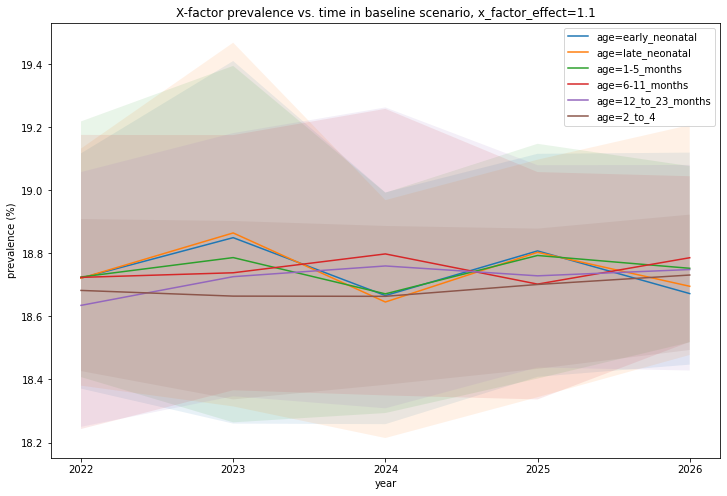

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
csp.plot_over_time_by_column(
    x_factor_prevalence.query("x_factor_effect==1.1 and scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'prevalence (%)',
    "X-factor prevalence vs. time in baseline scenario, x_factor_effect=1.1",
    True
)
figs['x_factor_prevalence_with_uncertainty_by_age_group_in_baseline_x_factor_1.1'] = fig

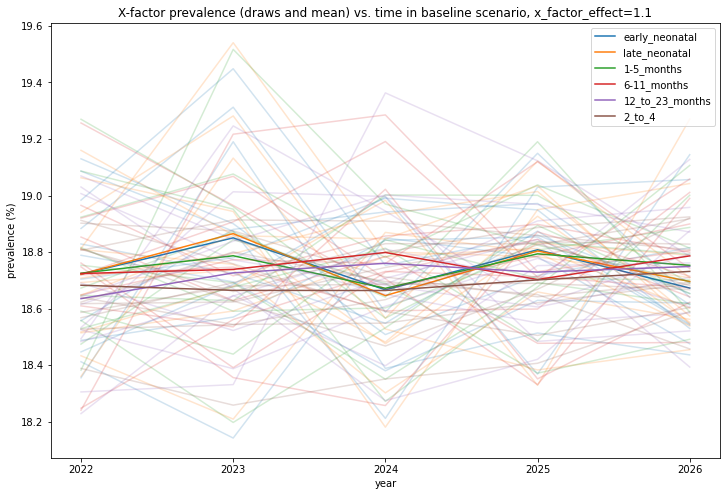

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
csp.plot_draws_over_time_by_age(
    x_factor_prevalence.query("x_factor_effect==1.1 and scenario=='baseline' and x_factor=='cat1'"),
    'prevalence (%)',
    "X-factor prevalence (draws and mean) vs. time in baseline scenario, x_factor_effect=1.1",
)
figs['x_factor_prevalence_draws_by_age_group_in_baseline_x_factor_1.1'] = fig

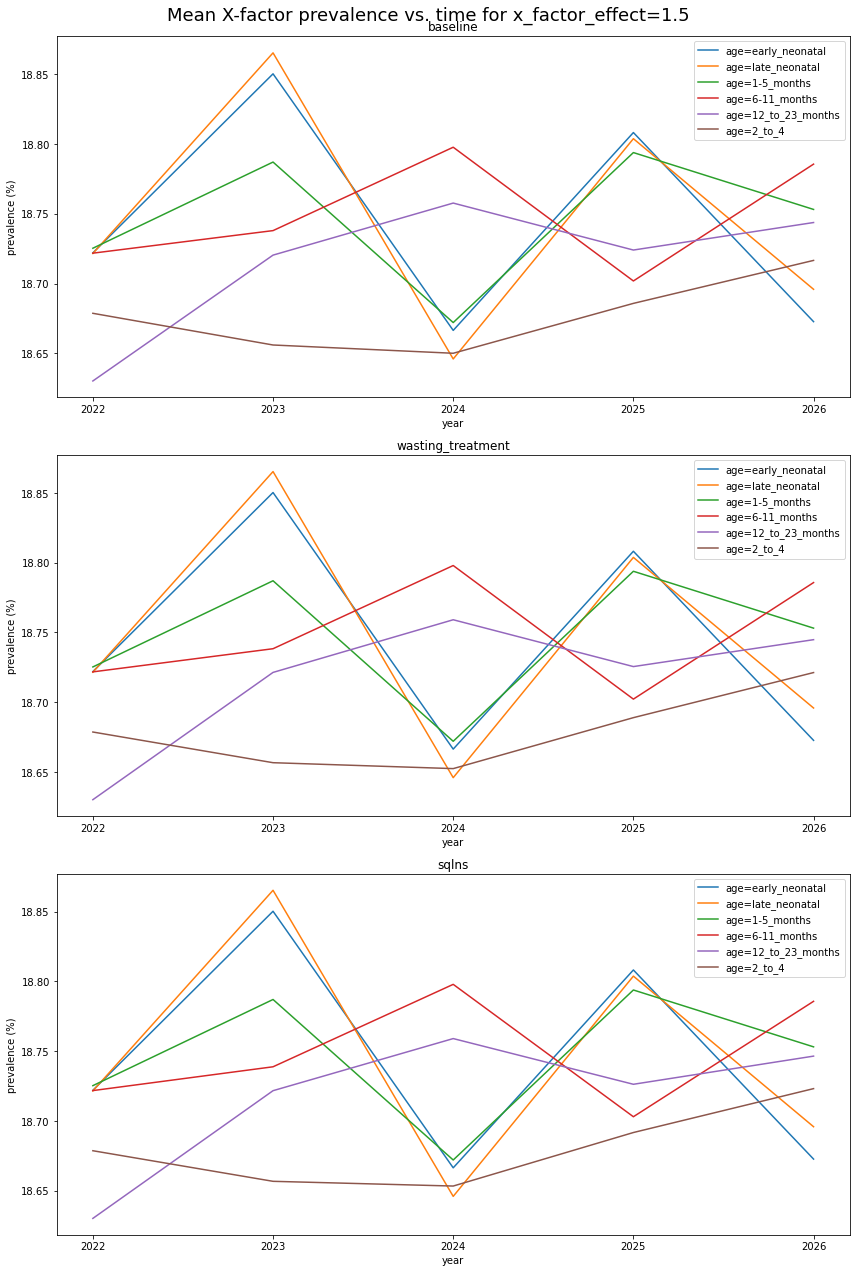

In [12]:
def plot_over_time_by_column_for_scenarios(df, colname, ylabel, suptitle):
    fig, axs = plt.subplots(len(csr.ordered_scenarios),1, figsize=(12,18))
    for s_num, scenario in enumerate(csr.ordered_scenarios):
        csp.plot_over_time_by_column(
            df.query("scenario==@scenario"),
            colname,
            ylabel,
            f"{scenario}",
            False,
            ax=axs[s_num],
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

x_factor_effect=1.5
fig = plot_over_time_by_column_for_scenarios(
    x_factor_prevalence.query(f"x_factor_effect=={x_factor_effect} and x_factor=='cat1'"),
    'age',
    ylabel='prevalence (%)',
    suptitle=f"Mean X-factor prevalence vs. time for {x_factor_effect=}",
)
figs['x_factor_prevalence_by_age_group_in_all_scenarios_x_factor_1.5'] = fig

# Define directories for saving figures

In [13]:
# project_results_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam'
model_name = 'v4.5.2_x_factor'
model_timestamp = '2021_09_29_12_12_47'
username = 'ndbs'

In [14]:
# model_count_data_dir = f'{project_results_dir}/{model_name}/ciff_sam/{model_timestamp}/count_data/'

project_vv_directory_name = 'ciff_malnutrition/verification_and_validation'

output_dir = f'/ihme/homes/{username}/vivarium_results/{project_vv_directory_name}/{model_name}'
share_output_dir = f'/share/scratch/users/ndbs/vivarium_results/{project_vv_directory_name}/{model_name}'
j_output_dir = f'/home/j/Project/simulation_science/{project_vv_directory_name}/{model_name}'

# Create the output directories if they don't exist
# Note from Path.mkdir() documentation:
#   "If mode is given, it is combined with the process’ umask value to determine the file mode and access flags."
#
# I don't know what this notebook process' umask value will be, so I don't know if this will actually result
# in the correct (most permissive) permissions for the directories...
for directory in [output_dir, share_output_dir, j_output_dir]:
    Path(directory).mkdir(mode=0o777, parents=True, exist_ok=True)

# Save figures to my home directory and J drive

In [15]:
list(figs.keys())

['x_factor_prevalence_by_age_group_in_baseline_x_factor_1.1',
 'x_factor_prevalence_by_age_group_in_baseline_x_factor_1.5',
 'x_factor_prevalence_with_uncertainty_by_age_group_in_baseline_x_factor_1.1',
 'x_factor_prevalence_draws_by_age_group_in_baseline_x_factor_1.1',
 'x_factor_prevalence_by_age_group_in_all_scenarios_x_factor_1.5']

In [16]:
for figure_name, fig in figs.items():
    for directory in [output_dir, j_output_dir]: 
        fig.savefig(f"{directory}/{figure_name}.pdf")

In [17]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v4.5.2_x_factor/

wasting_prevalence_by_age_group_averaged_over_x_factor.pdf
wasting_prevalence_by_age_group_x_factor_1.1.pdf
wasting_prevalence_by_age_group_x_factor_1.5.pdf
wasting_prevalence_by_x_factor_age_12-23_months.pdf
wasting_prevalence_by_x_factor_age_2_to_4.pdf
wasting_prevalence_by_x_factor_age_6-11_months.pdf
wasting_prevalence_by_x_factor_age_over_6mo_averaged.pdf
wasting_prevalence_by_x_factor_age_over_6mo.pdf
wasting_prevalence_by_x_factor_age_over_6mo_with_uncertainty.pdf
wasting_prevalence_by_x_factor_age_under_6mo_averaged.pdf
wasting_prevalence_by_x_factor_age_under_6mo.pdf
wasting_prevalence_by_x_factor_all_ages_with_uncertainty.pdf
wasting_prevalence_by_x_factor_among_no_x_factor.pdf
wasting_prevalence_by_x_factor_among_x_factor.pdf
x_factor_prevalence_by_age_group_in_all_scenarios_x_factor_1.5.pdf
x_factor_prevalence_by_age_group_in_baseline_x_factor_1.1.pdf
x_factor_prevalence_by_age_group_in_baseline_x_factor_1.5.pdf
x_factor_prevalence_draws_by_age_group_in_baseline_x_factor_1.

# Write a function to check that total person-time is equal for all cause state observers

In [18]:
data.cause_state_person_time

,sex,year,cause_state,measure,input_draw,scenario,x_factor_effect,value,wasting_state,age,cause
0,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,2.802190,susceptible_to_child_wasting,early_neonatal,diarrheal_diseases
1,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,0.706366,mild_child_wasting,early_neonatal,diarrheal_diseases
2,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,0.394251,moderate_acute_malnutrition,early_neonatal,diarrheal_diseases
3,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,0.112252,severe_acute_malnutrition,early_neonatal,diarrheal_diseases
...,...,...,...,...,...,...,...,...,...,...,...
259196,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,21982.043806,susceptible_to_child_wasting,2_to_4,measles
259197,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,7332.421629,mild_child_wasting,2_to_4,measles
259198,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,2161.859001,moderate_acute_malnutrition,2_to_4,measles
259199,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,415.915127,severe_acute_malnutrition,2_to_4,measles


In [19]:
cause_pt = vp.marginalize(data.cause_state_person_time, 'cause_state')
cause_pt

,age,cause,input_draw,measure,scenario,sex,wasting_state,x_factor_effect,year,value
0,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2022,856.239562
1,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2023,874.479124
2,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2024,903.897331
3,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2025,913.613963
...,...,...,...,...,...,...,...,...,...,...
129596,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2023,417.906913
129597,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2024,407.952088
129598,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2025,412.099932
129599,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2026,403.015743


In [20]:
first_cause, *remaining_causes = cause_pt.cause.unique()
pt = cause_pt.query("cause==@first_cause").drop(columns='cause')
for cause in remaining_causes:
    print(pt.equals(cause_pt.query("cause==@cause").drop(columns='cause')))
    vp.assert_values_equal(pt, cause_pt.query("cause==@cause").drop(columns='cause'))
pt

False
False


,age,input_draw,measure,scenario,sex,wasting_state,x_factor_effect,year,value
0,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2022,856.239562
1,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2023,874.479124
2,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2024,903.897331
3,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2025,913.613963
...,...,...,...,...,...,...,...,...,...
115196,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2023,417.906913
115197,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2024,407.952088
115198,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2025,412.099932
115199,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2026,403.015743


In [21]:
def assert_cause_person_time_equal(data):
    cause_person_time = csr.get_total_person_time(data, 'cause')
    first_cause, *remaining_causes = cause_person_time.cause.unique()
    person_time = cause_person_time.query("cause==@first_cause").drop(columns='cause')
    # Check that total person-time is the same for all causes
    for cause in remaining_causes:
        vp.assert_values_equal(person_time, cause_person_time.query("cause==@cause").drop(columns='cause'))

In [22]:
assert_cause_person_time_equal(data)